# PIV basics 1 

 start analasys of two picture from piv challenge going through the steps in PIV basics

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import correlate2d

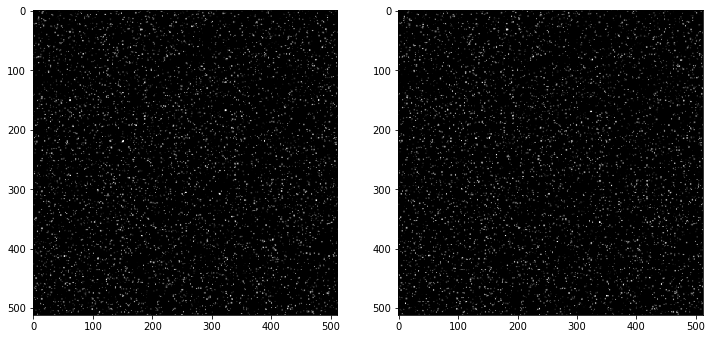

In [2]:

# load the images: 
a = plt.imread('B005_1.tif')
b = plt.imread('B005_2.tif')
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(a,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(b,cmap="gray")

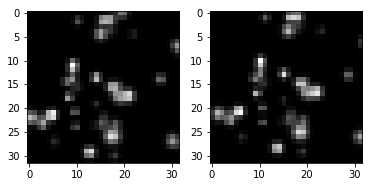

In [3]:
#interrogation windows. 
size=32 #size 32X32
ia = a[:size,:size].copy()
ib = b[:size,:size].copy()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ia,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(ib,cmap='gray')

let's look at the sustraction of both sub images: $im_a-im_b$ in order to spot the differences

Text(0.5,1,'Without shift')

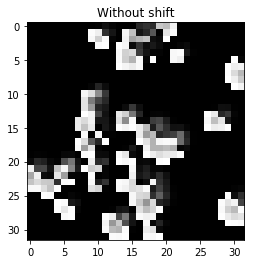

In [4]:
#lets start with simple substraction to find the displacemants between a to b
plt.imshow(ib-ia,cmap='gray')
plt.title('Without shift')

So the images are defenetley not the same. lets try to shift $image_a$ by 1 pixel 

Text(0.5,1,'Difference when IA has been shifted by 1 pixel')

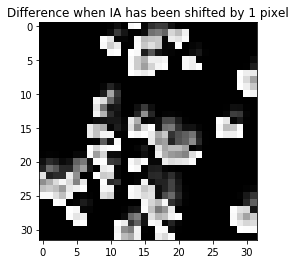

In [5]:
# lets shift ia by 1 pixle down
plt.imshow(ib-np.roll(ia,1,axis=0),cmap='gray')
plt.title('Difference when IA has been shifted by 1 pixel')

let's try to find the displacemant by going through all the combinations considering the maximun posible diplacemant is 8 pixels in each axis.

In [6]:
#lets find the displacemant
def match_template(img, template,maxroll=8):
    mindist = float('inf')
    idx = (0,0)
    for row in range(-maxroll,maxroll+1):
        for col in range(-maxroll,maxroll+1):
        #calculate Euclidean distance
            dist = np.sqrt(np.sum(np.square(template - np.roll(img,(row,col),axis=(0,1)))))
            if dist < mindist:
                mindist = dist
                idx = (row,col)
    return [mindist, idx]

In [7]:
# let's test that it works indeed by manually rolling (shifting circurlarly) the same image
match_template(ia,np.roll(ia,2,axis=0))

[0.0, (2, 0)]

it worked! we got zero distance and a displacemant of 2 pixels exactly what we expected.
let's apply it on the sub pictures.

In [12]:
# indeed, when we find the correct shift, we got zero distance. it's not so in real images:
mindist, idx = match_template(ia,ib)
print('Minimal distance = %f' % mindist)
print('idx = %d, %d' % idx)

Minimal distance = 123.802262
idx = -1, 1


firstly, the minimal distance is defentely not zero. But maybe it's good enough lets see the substraction on $im_b(i,j)-im_a(i,j+1)$

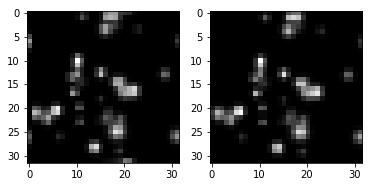

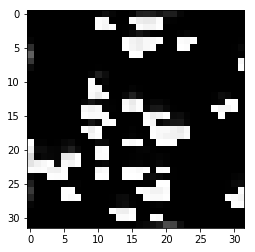

In [13]:
#lets check if it looks the same
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.roll(ia,idx,(0,1)),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(ib,cmap='gray')
plt.figure()
plt.imshow(np.roll(ia,idx,(0,1))-ib,cmap='gray')

Well it's not the exact shift indeed, but it is closer than before.
let's find all the shifts and time it using the simple algoritm we intreduced here.

In [18]:
iw=32
x,y,u_dif,v_dif,u_cor,v_cor = [],[],[],[],[],[]
for k in range(0,a.shape[0],iw):
    for m in range(0,a.shape[1],iw):
        ia = a[k:k+iw,m:m+iw].copy()
        ib = b[k:k+iw,m:m+iw].copy()
        cor, (i,j) = match_template(ia-ia.mean(),ib-ib.mean())
        y.append(k+iw/2.-1)
        x.append(m+iw/2.-1)
        u_dif.append(i)
        v_dif.append(j)
        c = correlate2d(ib-ib.mean(),ia-ia.mean())
        c=c[31-8:32+8,31-8:32+8]# we only aloow 8 pixels displacemant
        i,j = np.unravel_index(c.argmax(), c.shape)
        u_cor.append(i -8)
        v_cor.append(j- 8)
        

        
    

Text(0.5,1,'vector field using scipys crosscoraation2d')

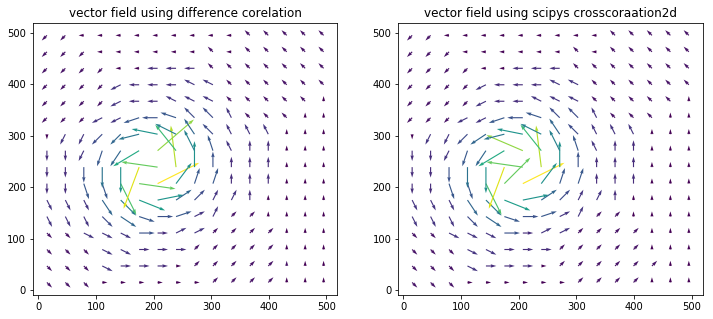

In [38]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
M_dif= np.sqrt(pow(np.array(u_dif), 2) + pow(np.array(v_dif), 2))
plt.quiver(x,y,v_dif,u_dif,M)
plt.title('vector field using difference corelation')
plt.subplot(1,2,2)
M_cor = np.sqrt(pow(np.array(u_cor), 2) + pow(np.array(v_cor), 2))
plt.quiver(x,y,v_cor,u_cor,M)
plt.title('vector field using scipys crosscoraation2d')

the results are mainly the same except for acouple points in the middle.
We should explore and undertand where the change come from.

In [55]:
#the results are abit different les find why
q=np.array(M_dif)==np.array(M_cor)
problem_index=np.where(q==False)
print('The problematic indexes having different results using different correlations:'+ str(problem_index))

The problematic indexes having different results using different correlations:(array([ 29, 134, 148], dtype=int64),)


let's explore one of the problematic points i=134

In [67]:
k=int(y[problem_index[0][1]]-(iw/2.-1))
m=int(x[problem_index[0][1]]-(iw/2.-1))
ia = a[k:k+iw,m:m+iw].copy()
ib = b[k:k+iw,m:m+iw].copy()
mindist, idx = match_template(ia-ia.mean(),ib-ib.mean())
print('Minimal distance = %f' % mindist)
print('idx = %d, %d' % idx)
c = correlate2d(ib-ib.mean(),ia-ia.mean())
i,j = np.unravel_index(c.argmax(), c.shape)
print('cor2d:%d,%d'%(i-31,j-31))

Minimal distance = 713.291304
idx = 6, 7
cor2d:3,-7


The displacemant we got in the first problematic index are different in did! we should dig deeper.

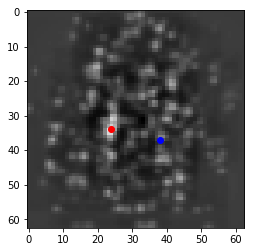

In [68]:
plt.imshow(c,cmap='gray')
plt.plot(j,i,'ro')
plt.plot(31+idx[1],31+idx[0],'bo')

In [73]:
print('cross correlation of blue point=%d' % c[31+idx[0],31+idx[1]]) #mindif check in crosscorelation
print('cross correlation of red point=%d' % c.max()) #max crosscorraltion 
dist_diff = np.sqrt(np.sum(np.square((ib-ib.mean()) - (np.roll(ia,(idx[0],idx[1]),axis=(0,1))-ia.mean()))))#CHECK MINDIF
dist_cor= np.sqrt(np.sum(np.square((ib-ib.mean()) - (np.roll(ia,(i-31,j-31),axis=(0,1))-ia.mean()))))#CHECK WHAT THE DIF FROM THE CROSSCORRELATION
print('min difference of red point=%d' % dist_cor)
print('min difference of blue point=%d' % dist_diff)
np.sum((ib-ib.mean())*(np.roll(ia,(i-31,j-31),axis=(0,1))-ia.mean())) #check if crosscorralatio is miltiplicATION
np.sum((ib-ib.mean())*(np.roll(ia,(idx[0],idx[1]),axis=(0,1))-ia.mean()))

cross correlation of blue point=16237
cross correlation of red point=81943
min difference of red point=724
min difference of blue point=713


80195.0

## we have aproblem!